**Лабораторная работа 1. Исследование набора данных**


## 1. Постановка задачи
В этой работе выбирается набор данных, проводится предобработка и статистический анализ, визуализация распределений,
поиск выбросов, анализ пропусков и корреляционный анализ для выбора подходящих алгоритмов кластеризации и классификации.



## 2. Выбор исследуемого датасета

**Выбранный датасет:** UCI Wine (распознавание сортов виноградной лозы).  
**Предметная область:** химический анализ вин и классификация по сорту (3 класса).  
**Источник данных:** UCI Machine Learning Repository / встроен в `scikit-learn` как `load_wine`.  
**Характер данных:** реальные химические измерения образцов вина из региона Италии.  
**Размерность:** 178 объектов × 13 числовых признаков + целевая метка (класс).  
**Типы признаков:** все 13 признаков числовые (непрерывные).  
**Цель анализа:** исследовать структуру данных, распределения, взаимосвязи, а также подготовить данные для будущих задач классификации/кластеризации.

**Список признаков (обозначение → краткое описание):**
- `alcohol` → содержание алкоголя (%)
- `malic_acid` → яблочная кислота
- `ash` → зола
- `alcalinity_of_ash` → щелочность золы
- `magnesium` → магний (мг/дм³)
- `total_phenols` → суммарные фенолы
- `flavanoids` → флаваноиды
- `nonflavanoid_phenols` → нефлавоноидные фенолы
- `proanthocyanins` → проантоцианидины
- `color_intensity` → интенсивность окраски
- `hue` → оттенок
- `od280/od315_of_diluted_wines` → показатель OD280/OD315
- `proline` → пролин



## 3. Подготовка окружения и загрузка данных


In [10]:

!pip install pandas numpy matplotlib scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_wine

# Настройки вывода
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)

# Загрузка датасета Wine
wine = load_wine()
X = pd.DataFrame(wine.data, columns=wine.feature_names)
y = pd.Series(wine.target, name='target')
target_names = wine.target_names

# Объединяем в один DataFrame для удобства анализа
df = X.copy()
df['target'] = y

print(f"Форма данных: {df.shape[0]} объектов × {df.shape[1]} столбцов")
df.head()


Форма данных: 178 объектов × 14 столбцов


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0



## 4. Описание атрибутов и их типы
Ниже приведены типы данных признаков и целевой метки.


In [11]:

types = pd.DataFrame({
    'column': df.columns,
    'dtype': df.dtypes.astype(str)
})
types


,column,dtype
alcohol,alcohol,float64
malic_acid,malic_acid,float64
ash,ash,float64
alcalinity_of_ash,alcalinity_of_ash,float64
magnesium,magnesium,float64
total_phenols,total_phenols,float64
flavanoids,flavanoids,float64
nonflavanoid_phenols,nonflavanoid_phenols,float64
proanthocyanins,proanthocyanins,float64
color_intensity,color_intensity,float64



## 5. Статистики по признакам
Для **каждого признака** рассчитаны среднее значение и стандартное отклонение.


In [12]:

stats = pd.DataFrame({
    'mean': X.mean(),
    'std': X.std(ddof=1)
}).round(4)
stats


,mean,std
alcohol,13.0006,0.8118
malic_acid,2.3363,1.1171
ash,2.3665,0.2743
alcalinity_of_ash,19.4949,3.3396
magnesium,99.7416,14.2825
total_phenols,2.2951,0.6259
flavanoids,2.0293,0.9989
nonflavanoid_phenols,0.3619,0.1245
proanthocyanins,1.5909,0.5724
color_intensity,5.0581,2.3183



## 6. Гистограммы распределений и выбросы

Для каждого признака строится гистограмма. Выбросы дополнительно оцениваются **IQR-методом** (межквартильный размах).


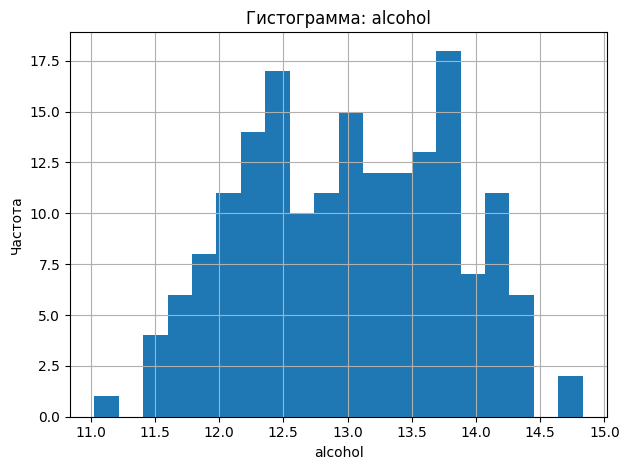

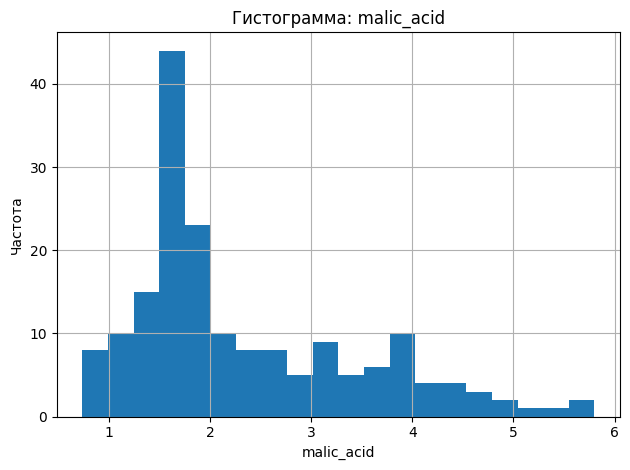

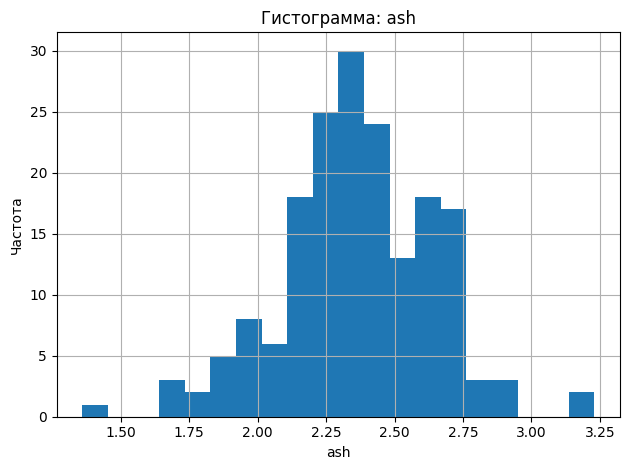

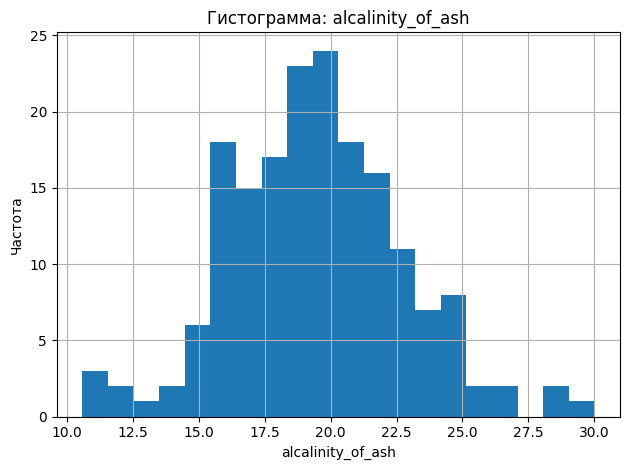

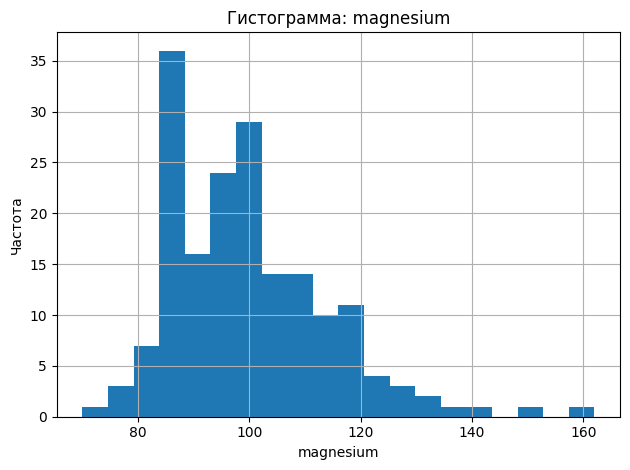

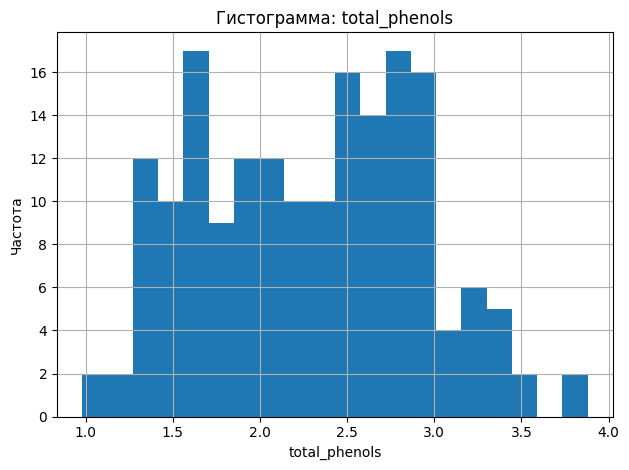

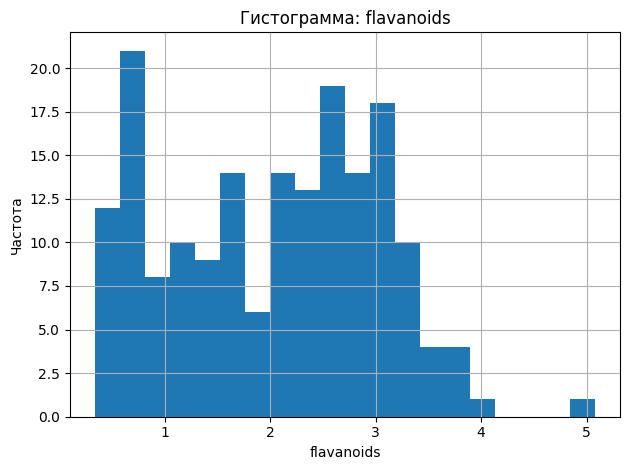

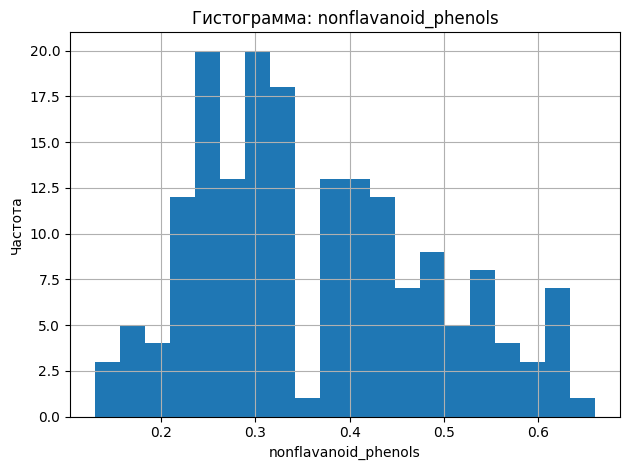

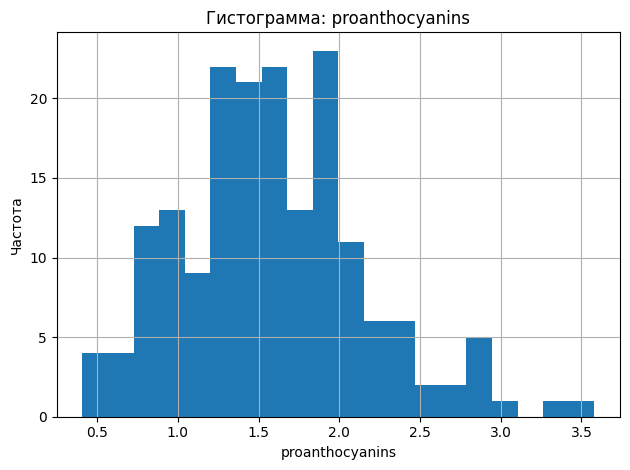

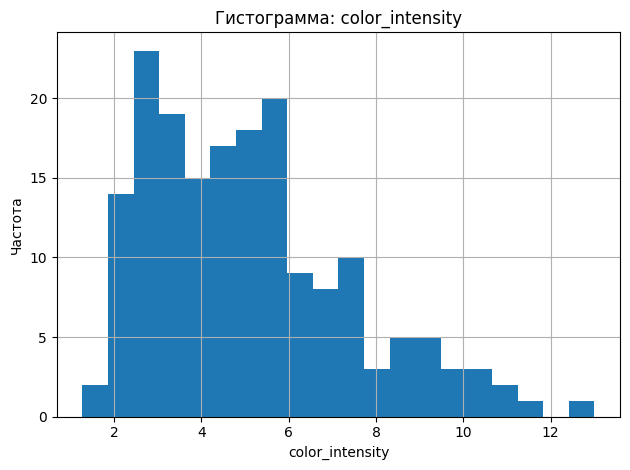

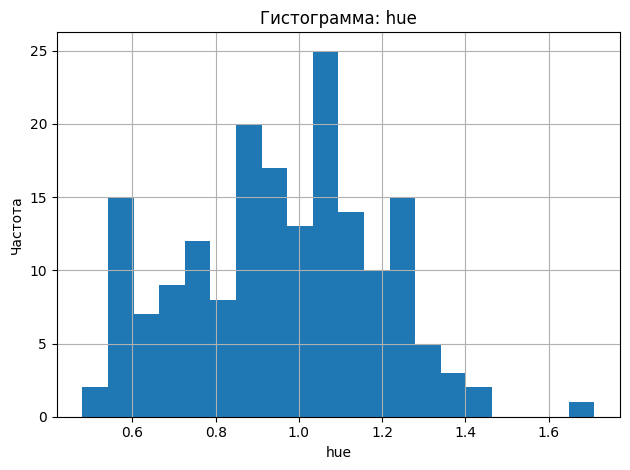

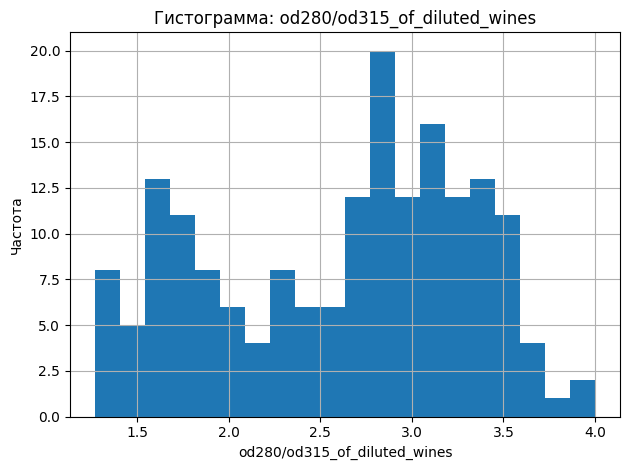

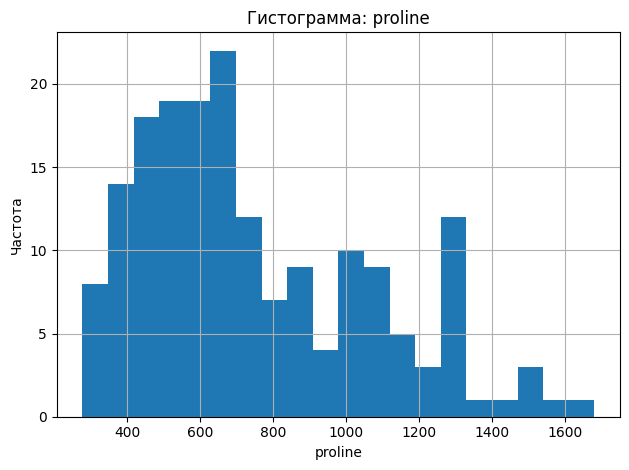

In [13]:

# Гистограммы: один график на один признак (без подграфиков)
for col in X.columns:
    plt.figure()
    X[col].hist(bins=20)
    plt.title(f'Гистограмма: {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.tight_layout()
    plt.show()


In [14]:

def iqr_outliers_count(series: pd.Series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    mask = (series < lower) | (series > upper)
    return mask.sum(), lower, upper

outlier_summary = []
for col in X.columns:
    cnt, lower, upper = iqr_outliers_count(X[col])
    outlier_summary.append({'feature': col, 'outliers_count': int(cnt), 'lower_bound': lower, 'upper_bound': upper})

outlier_df = pd.DataFrame(outlier_summary).sort_values('outliers_count', ascending=False).reset_index(drop=True)
outlier_df


,feature,outliers_count,lower_bound,upper_bound
0,magnesium,4,59.50000,135.50000
1,alcalinity_of_ash,4,10.75000,27.95000
2,color_intensity,4,-1.25000,10.67000
3,malic_acid,3,-0.61750,5.30250
4,ash,3,1.68875,3.07875
5,proanthocyanins,2,0.20000,3.00000
6,hue,1,0.27625,1.62625
7,alcohol,0,10.39000,15.65000
8,total_phenols,0,0.15625,4.38625
9,nonflavanoid_phenols,0,0.01875,0.68875



## 7. Пропущенные значения

Проверим наличие пропусков и предложим стратегии обработки.


In [15]:

missing = df.isna().sum().to_frame('missing_count')
missing['missing_pct'] = (missing['missing_count'] / len(df) * 100).round(2)
missing


,missing_count,missing_pct
alcohol,0,0.0
malic_acid,0,0.0
ash,0,0.0
alcalinity_of_ash,0,0.0
magnesium,0,0.0
total_phenols,0,0.0
flavanoids,0,0.0
nonflavanoid_phenols,0,0.0
proanthocyanins,0,0.0
color_intensity,0,0.0



Этот датасет не содержит пропусков. Если бы пропуски были, возможные подходы:
- для числовых признаков: импутация средним/медианой; продвинуто — `KNNImputer`/модели;
- для категориальных: самый частый класс или явная категория `"Missing"`;
- удаление строк/столбцов при высокой доле пропусков (зависит от задачи и объёма данных).


In [16]:

# Пример кода импутации (не выполняется здесь, т.к. пропусков нет)
# from sklearn.impute import SimpleImputer
# num_imputer = SimpleImputer(strategy='median')
# X_imputed = pd.DataFrame(num_imputer.fit_transform(X), columns=X.columns)
# X_imputed.head()



## 8. Корреляционный анализ

Вычислим корреляцию Пирсона между числовыми признаками, построим тепловую карту и выделим пары с высокой/низкой связью.


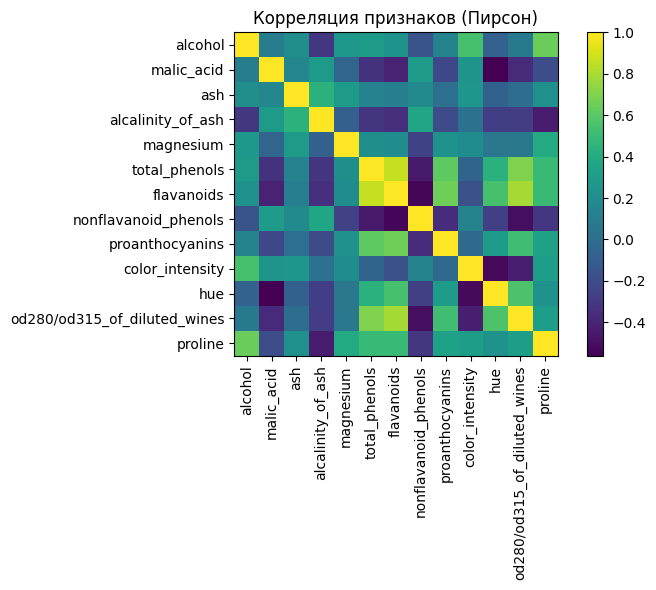

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
alcohol,1.000,0.094,0.212,-0.310,0.271,0.289,0.237,-0.156,0.137,0.546,-0.072,0.072,0.644
malic_acid,0.094,1.000,0.164,0.289,-0.055,-0.335,-0.411,0.293,-0.221,0.249,-0.561,-0.369,-0.192
ash,0.212,0.164,1.000,0.443,0.287,0.129,0.115,0.186,0.010,0.259,-0.075,0.004,0.224
alcalinity_of_ash,-0.310,0.289,0.443,1.000,-0.083,-0.321,-0.351,0.362,-0.197,0.019,-0.274,-0.277,-0.441
magnesium,0.271,-0.055,0.287,-0.083,1.000,0.214,0.196,-0.256,0.236,0.200,0.055,0.066,0.393
total_phenols,0.289,-0.335,0.129,-0.321,0.214,1.000,0.865,-0.450,0.612,-0.055,0.434,0.700,0.498
flavanoids,0.237,-0.411,0.115,-0.351,0.196,0.865,1.000,-0.538,0.653,-0.172,0.543,0.787,0.494
nonflavanoid_phenols,-0.156,0.293,0.186,0.362,-0.256,-0.450,-0.538,1.000,-0.366,0.139,-0.263,-0.503,-0.311
proanthocyanins,0.137,-0.221,0.010,-0.197,0.236,0.612,0.653,-0.366,1.000,-0.025,0.296,0.519,0.330
color_intensity,0.546,0.249,0.259,0.019,0.200,-0.055,-0.172,0.139,-0.025,1.000,-0.522,-0.429,0.316


In [17]:

corr = X.corr(numeric_only=True)

# Тепловая карта с matplotlib (без seaborn)
plt.figure(figsize=(8, 6))
plt.imshow(corr, interpolation='nearest')
plt.title('Корреляция признаков (Пирсон)')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.tight_layout()
plt.show()

corr.round(3)


In [18]:

# Списки сильно/слабо коррелирующих пар
import itertools

pairs = []
for i, j in itertools.combinations(range(len(corr.columns)), 2):
    f1, f2 = corr.columns[i], corr.columns[j]
    r = corr.iloc[i, j]
    pairs.append((f1, f2, r))

pairs_sorted = sorted(pairs, key=lambda x: abs(x[2]), reverse=True)

high = [(a, b, round(r, 3)) for a, b, r in pairs_sorted if abs(r) >= 0.7]
low  = [(a, b, round(r, 3)) for a, b, r in pairs_sorted if abs(r) <= 0.1]

pd.DataFrame({'high_corr_pairs(|r|≥0.7)': [high[:10]], 'low_corr_pairs(|r|≤0.1)': [low[:10]]})


,high_corr_pairs(|r|≥0.7),low_corr_pairs(|r|≤0.1)
0,"[(total_phenols, flavanoids, 0.865), (flavanoi...","[(alcohol, malic_acid, 0.094), (alcalinity_of_..."



## 9. Графики рассеивания (по парам признаков)

Ниже построены графики рассеивания для нескольких пар признаков: несколько с высокой корреляцией и парочка с низкой
(для наглядности). Точки окрашены по классам (`target`). Каждый график — отдельный рисунок (без подграфиков).


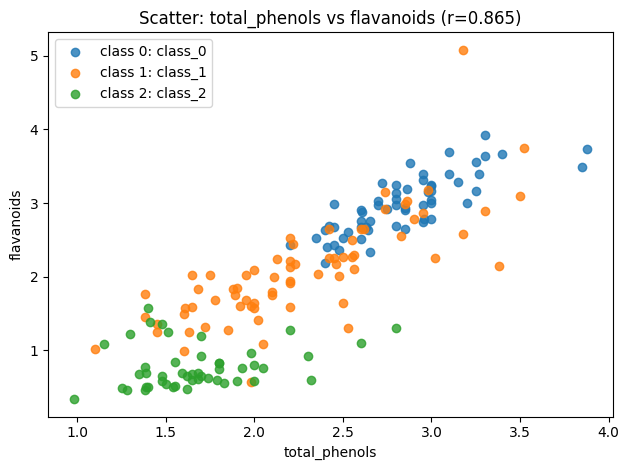

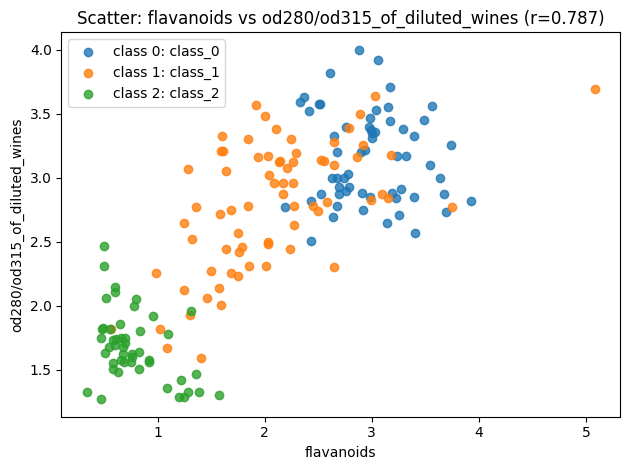

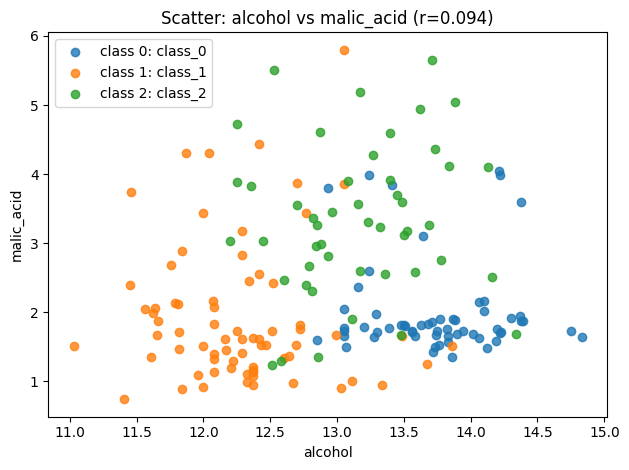

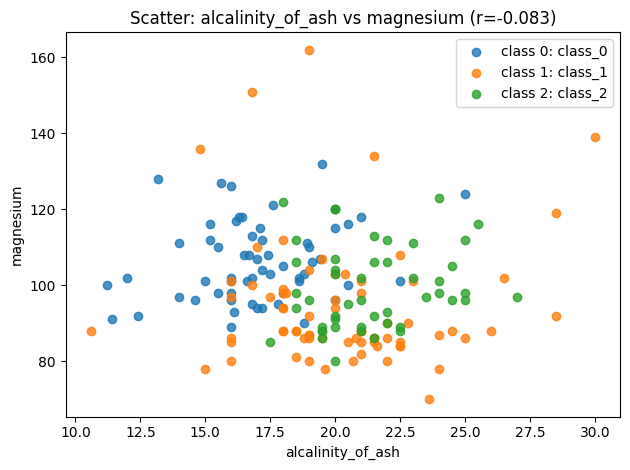

In [19]:

# Выберем топ-3 сильно коррелирующих и 2 с низкой корреляцией
top_high = [p for p in pairs_sorted if abs(p[2]) >= 0.7][:3]
top_low  = [p for p in pairs_sorted if abs(p[2]) <= 0.1][:2]
selected = top_high + top_low

# Палитра/метки для классов (matplotlib подставит свои цвета по умолчанию)
class_values = sorted(y.unique())
class_labels = [str(target_names[i]) for i in class_values]

for a, b, r in selected:
    plt.figure()
    for cls in class_values:
        mask = (y == cls)
        plt.scatter(X.loc[mask, a], X.loc[mask, b], label=f'class {cls}: {target_names[cls]}', alpha=0.8)
    plt.xlabel(a)
    plt.ylabel(b)
    plt.title(f'Scatter: {a} vs {b} (r={r:.3f})')
    plt.legend()
    plt.tight_layout()
    plt.show()



## 10. Выводы

- Данные **реальные**, сбалансированные по числовым признакам (13 фич), целевая переменная — 3 класса сортов.
- Распределения признаков различаются по форме; по IQR-правилу в некоторых признаках есть потенциальные **выбросы** — их стоит дополнительно проверять в контексте предметной области.
- Пропусков **нет**; при появлении пропусков разумна импутация медианой (для устойчивости к выбросам).
- Наблюдаются **сильные корреляции** (например, `total_phenols`–`flavanoids`, `od280/od315`–`flavanoids`, и др.), а также пары со слабой связью.
- Визуализации (гистограммы, тепловая карта, scatter) показывают разделимость классов по ряду признаков, что перспективно для задач классификации; для кластеризации стоит учитывать коррелированные признаки (возможно, предварительно применить PCA).
